In [13]:
import pandas as pd
import numpy as np
import re
import copy

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime, timedelta

import seaborn as sns
sns.set_style('white')

#### corin's attempts to fit random forest to data

In [61]:
import tensorflow as tf

print(tf.__version__)  # You should see a 2.0.0 here!

import tensorflow.keras as keras

from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.layers import Flatten
from keras.layers.embeddings import Embedding

2.0.0


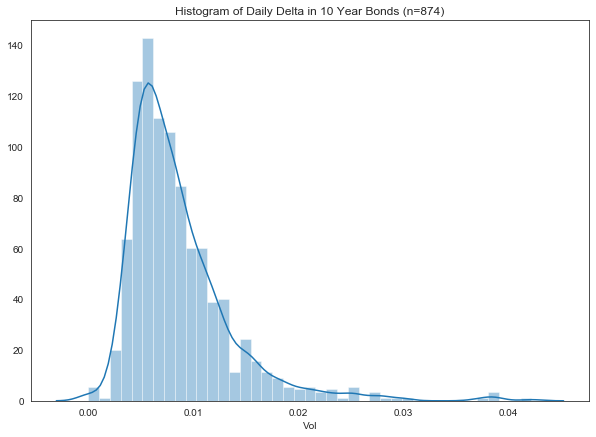

In [4]:
bonds_10 = pd.read_csv('../bonds/adjusted^TNX.csv')
bonds_10['Vol'] = (bonds_10['High'] - bonds_10['Low']) / (bonds_10['High'] + bonds_10['Low'])
#print(bonds_10.head(10))

bonds_30 = pd.read_csv('../bonds/adjusted^TYX.csv')
bonds_30['Vol'] = (bonds_30['High'] - bonds_30['Low']) / (bonds_30['High'] + bonds_30['Low'])
#print(bonds_30.head(10))

fig = plt.figure(figsize=(10,7))
sns.distplot(bonds_10['Vol'])
plt.title(f'Histogram of Daily Delta in 10 Year Bonds (n={len(bonds_10)})')

plt.show()

In [11]:
predictors = pd.read_csv('../tweets/cleaned_tweet_text_by_day')
print(predictors.info())

pred_bonds_10 = pd.merge(left=bonds_10, right=predictors, on='Date') # default is INNER join which is what we want
pred_cols = ['clean_text']

def add_lookback_predictors(df, columns, num_days=10):
    df.sort_values(by=['Date'])
    new_cols = copy.deepcopy(columns)
    
    for idx, row in df.iterrows():
        if idx < num_days:
            continue
        for col in columns:
            for day in range(1,num_days+1):
                new_cols.append(f"{col}_{day}")
                df.loc[idx, f"{col}_{day}"] = df.loc[idx-day, col]
    
    return list(set(new_cols)) # need unique
        
pred_cols2 = add_lookback_predictors(pred_bonds_10, pred_cols, num_days=10)
print(pred_cols2[-20:])
pred_bonds_10.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1006 entries, 0 to 1005
Data columns (total 8 columns):
Unnamed: 0    1006 non-null float64
Unnamed: 1    1006 non-null float64
Unnamed: 2    1006 non-null float64
clean_text    1005 non-null object
year          1006 non-null float64
month         1006 non-null float64
day           1006 non-null float64
Date          1006 non-null object
dtypes: float64(6), object(2)
memory usage: 63.0+ KB
None
['clean_text_2', 'clean_text', 'clean_text_10', 'clean_text_3', 'clean_text_5', 'clean_text_8', 'clean_text_6', 'clean_text_7', 'clean_text_9', 'clean_text_4', 'clean_text_1']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 839 entries, 0 to 838
Data columns (total 26 columns):
Unnamed: 0_x     839 non-null int64
Date             839 non-null object
Open             839 non-null float64
High             839 non-null float64
Low              839 non-null float64
Close            839 non-null float64
Adj.Close        839 non-null float64
Volume

In [32]:
vocab_size = 5000
encoded_docs = [one_hot(d, vocab_size) for d in pred_bonds_10['clean_text']]

# pad documents to a max length of 4 words
max_length = 50
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

X = padded_docs[0:668]
Xt = padded_docs[669:829]

y = pred_bonds_10['Vol'][0:668]
yt = pred_bonds_10['Vol'][669:829]

#### adapted from https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

In [108]:
kernel_reg = tf.keras.regularizers.l1_l2(l1=0.00001, l2=0.001)
dropout_c = 0.2

# define the model
model = Sequential()
model.add(Embedding(vocab_size, 8, input_length=max_length))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=kernel_reg,))
model.add(Dropout(dropout_c))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu', kernel_regularizer=kernel_reg,))
model.add(Dropout(dropout_c))
model.add(Dense(32, activation='relu', kernel_regularizer=kernel_reg,))
#model.add(BatchNormalization())
model.add(Dense(1, activation='linear'))

# compile the model
model.compile(loss='mean_absolute_error', optimizer='adam')

# summarize the model
print(model.summary())

# fit the model
history = model.fit(X, y, epochs=500, batch_size=32, verbose=1, validation_split=0.2)
# evaluate the model

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_47 (Embedding)     (None, 50, 8)             40000     
_________________________________________________________________
flatten_47 (Flatten)         (None, 400)               0         
_________________________________________________________________
dense_156 (Dense)            (None, 128)               51328     
_________________________________________________________________
dropout_47 (Dropout)         (None, 128)               0         
_________________________________________________________________
batch_normalization_23 (Batc (None, 128)               512       
_________________________________________________________________
dense_157 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_48 (Dropout)         (None, 128)             

/usr/local/anaconda3/envs/py3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 534 samples, validate on 134 samples
Epoch 1/500
534/534 [==============================] - 3s 5ms/step - loss: 0.7233 - val_loss: 0.4241
Epoch 2/500
534/534 [==============================] - 0s 303us/step - loss: 0.6489 - val_loss: 0.4183
Epoch 3/500
534/534 [==============================] - 0s 294us/step - loss: 0.5627 - val_loss: 0.4198
Epoch 4/500
534/534 [==============================] - 0s 294us/step - loss: 0.5238 - val_loss: 0.4060
Epoch 5/500
534/534 [==============================] - 0s 294us/step - loss: 0.4951 - val_loss: 0.4006
Epoch 6/500
534/534 [==============================] - 0s 297us/step - loss: 0.4774 - val_loss: 0.3909
Epoch 7/500
534/534 [==============================] - 0s 297us/step - loss: 0.4533 - val_loss: 0.3824
Epoch 8/500
534/534 [==============================] - 0s 303us/step - loss: 0.4341 - val_loss: 0.3745
Epoch 9/500
534/534 [==============================] - 0s 308us/step - loss: 0.4161 - val_loss: 0.3688
Epoch 10/500
534/534 [=======

534/534 [==============================] - 0s 347us/step - loss: 0.0347 - val_loss: 0.0344
Epoch 80/500
534/534 [==============================] - 0s 330us/step - loss: 0.0331 - val_loss: 0.0328
Epoch 81/500
534/534 [==============================] - 0s 332us/step - loss: 0.0316 - val_loss: 0.0314
Epoch 82/500
534/534 [==============================] - 0s 333us/step - loss: 0.0302 - val_loss: 0.0303
Epoch 83/500
534/534 [==============================] - 0s 333us/step - loss: 0.0290 - val_loss: 0.0287
Epoch 84/500
534/534 [==============================] - 0s 329us/step - loss: 0.0276 - val_loss: 0.0274
Epoch 85/500
534/534 [==============================] - 0s 332us/step - loss: 0.0262 - val_loss: 0.0263
Epoch 86/500
534/534 [==============================] - 0s 388us/step - loss: 0.0250 - val_loss: 0.0250
Epoch 87/500
534/534 [==============================] - 0s 358us/step - loss: 0.0237 - val_loss: 0.0241
Epoch 88/500
534/534 [==============================] - 0s 340us/step - loss:

534/534 [==============================] - 0s 442us/step - loss: 0.0024 - val_loss: 0.0042
Epoch 158/500
534/534 [==============================] - 0s 378us/step - loss: 0.0024 - val_loss: 0.0041
Epoch 159/500
534/534 [==============================] - 0s 349us/step - loss: 0.0024 - val_loss: 0.0043
Epoch 160/500
534/534 [==============================] - 0s 363us/step - loss: 0.0024 - val_loss: 0.0042
Epoch 161/500
534/534 [==============================] - 0s 352us/step - loss: 0.0025 - val_loss: 0.0041
Epoch 162/500
534/534 [==============================] - 0s 358us/step - loss: 0.0024 - val_loss: 0.0043
Epoch 163/500
534/534 [==============================] - 0s 336us/step - loss: 0.0023 - val_loss: 0.0039
Epoch 164/500
534/534 [==============================] - 0s 351us/step - loss: 0.0023 - val_loss: 0.0045
Epoch 165/500
534/534 [==============================] - 0s 355us/step - loss: 0.0024 - val_loss: 0.0040
Epoch 166/500
534/534 [==============================] - 0s 342us/ste

534/534 [==============================] - 0s 342us/step - loss: 0.0017 - val_loss: 0.0035
Epoch 236/500
534/534 [==============================] - 0s 345us/step - loss: 0.0016 - val_loss: 0.0036
Epoch 237/500
534/534 [==============================] - 0s 340us/step - loss: 0.0016 - val_loss: 0.0036
Epoch 238/500
534/534 [==============================] - 0s 346us/step - loss: 0.0016 - val_loss: 0.0036
Epoch 239/500
534/534 [==============================] - 0s 342us/step - loss: 0.0016 - val_loss: 0.0036
Epoch 240/500
534/534 [==============================] - 0s 345us/step - loss: 0.0016 - val_loss: 0.0034
Epoch 241/500
534/534 [==============================] - 0s 349us/step - loss: 0.0015 - val_loss: 0.0034
Epoch 242/500
534/534 [==============================] - 0s 341us/step - loss: 0.0017 - val_loss: 0.0037
Epoch 243/500
534/534 [==============================] - 0s 341us/step - loss: 0.0017 - val_loss: 0.0032
Epoch 244/500
534/534 [==============================] - 0s 345us/ste

534/534 [==============================] - 0s 351us/step - loss: 0.0015 - val_loss: 0.0031
Epoch 314/500
534/534 [==============================] - 0s 353us/step - loss: 0.0014 - val_loss: 0.0031
Epoch 315/500
534/534 [==============================] - 0s 341us/step - loss: 0.0015 - val_loss: 0.0033
Epoch 316/500
534/534 [==============================] - 0s 346us/step - loss: 0.0014 - val_loss: 0.0034
Epoch 317/500
534/534 [==============================] - 0s 344us/step - loss: 0.0016 - val_loss: 0.0032
Epoch 318/500
534/534 [==============================] - 0s 359us/step - loss: 0.0014 - val_loss: 0.0034
Epoch 319/500
534/534 [==============================] - 0s 343us/step - loss: 0.0016 - val_loss: 0.0032
Epoch 320/500
534/534 [==============================] - 0s 360us/step - loss: 0.0016 - val_loss: 0.0032
Epoch 321/500
534/534 [==============================] - 0s 405us/step - loss: 0.0016 - val_loss: 0.0037
Epoch 322/500
534/534 [==============================] - 0s 451us/ste

534/534 [==============================] - 0s 361us/step - loss: 0.0013 - val_loss: 0.0032
Epoch 392/500
534/534 [==============================] - 0s 356us/step - loss: 0.0013 - val_loss: 0.0033
Epoch 393/500
534/534 [==============================] - 0s 341us/step - loss: 0.0013 - val_loss: 0.0031
Epoch 394/500
534/534 [==============================] - 0s 417us/step - loss: 0.0014 - val_loss: 0.0033
Epoch 395/500
534/534 [==============================] - 0s 382us/step - loss: 0.0019 - val_loss: 0.0039
Epoch 396/500
534/534 [==============================] - 0s 408us/step - loss: 0.0015 - val_loss: 0.0031
Epoch 397/500
534/534 [==============================] - 0s 353us/step - loss: 0.0015 - val_loss: 0.0030
Epoch 398/500
534/534 [==============================] - 0s 350us/step - loss: 0.0014 - val_loss: 0.0031
Epoch 399/500
534/534 [==============================] - 0s 433us/step - loss: 0.0014 - val_loss: 0.0031
Epoch 400/500
534/534 [==============================] - 0s 435us/ste

534/534 [==============================] - 0s 361us/step - loss: 0.0013 - val_loss: 0.0032
Epoch 470/500
534/534 [==============================] - 0s 340us/step - loss: 0.0014 - val_loss: 0.0030
Epoch 471/500
534/534 [==============================] - 0s 342us/step - loss: 0.0014 - val_loss: 0.0029
Epoch 472/500
534/534 [==============================] - 0s 347us/step - loss: 0.0014 - val_loss: 0.0030
Epoch 473/500
534/534 [==============================] - 0s 338us/step - loss: 0.0013 - val_loss: 0.0031
Epoch 474/500
534/534 [==============================] - 0s 328us/step - loss: 0.0013 - val_loss: 0.0032
Epoch 475/500
534/534 [==============================] - 0s 339us/step - loss: 0.0013 - val_loss: 0.0034
Epoch 476/500
534/534 [==============================] - 0s 332us/step - loss: 0.0014 - val_loss: 0.0031
Epoch 477/500
534/534 [==============================] - 0s 332us/step - loss: 0.0014 - val_loss: 0.0030
Epoch 478/500
534/534 [==============================] - 0s 329us/ste

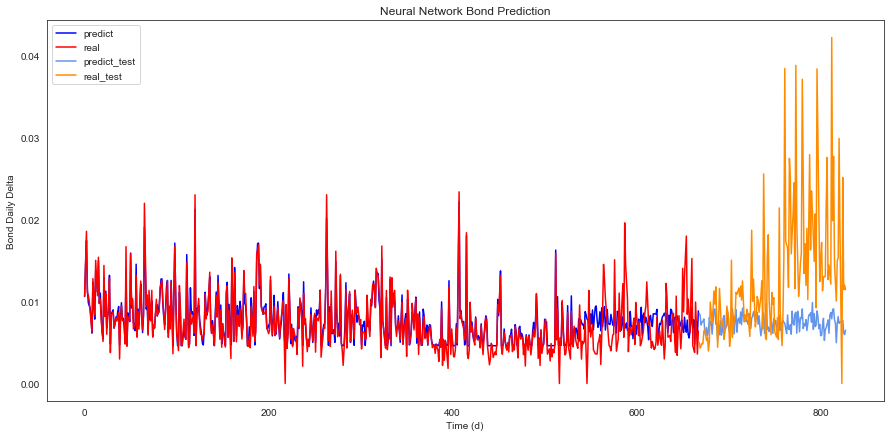

In [109]:
fig = plt.figure(figsize=(15,7))

pred_y = model.predict(X, verbose=0)
pred_yt = model.predict(Xt, verbose=0)

plt.title('Neural Network Bond Prediction')
plt.ylabel('Bond Daily Delta')
plt.xlabel('Time (d)')

plt.plot(range(len(y)), pred_y, c='b', label='predict')
plt.plot(range(len(y)), y, c='r', label='real')
plt.plot(range(len(y),len(yt)+len(y)), pred_yt, c='cornflowerblue', label='predict_test')
plt.plot(range(len(y),len(yt)+len(y)), yt, c='darkorange', label='real_test')

plt.legend(loc='best')
plt.show()

0.0013076663666931486
0.0031283409091463284


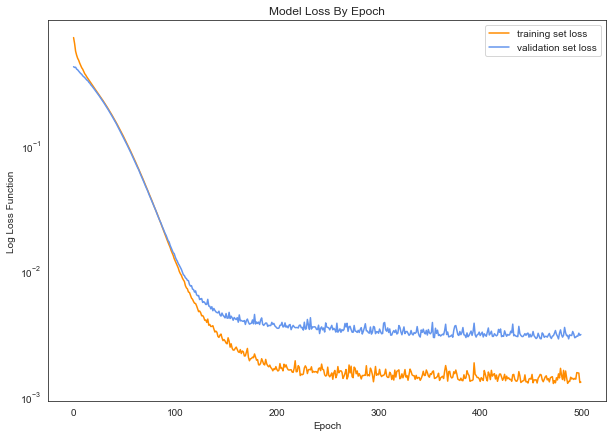

In [110]:
def plot_history(history, ax):
    ax.set_yscale("log", nonposy='clip')
    ax.plot(range(len(history.history['loss'])), history.history['loss'], color='darkorange', label='training set loss')
    ax.plot(range(len(history.history['val_loss'])), history.history['val_loss'], color='cornflowerblue', label='validation set loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Log Loss Function')
    ax.set_title('Model Loss By Epoch')
    ax.legend(loc='best')
    
figure = plt.figure(figsize=(10,7))
print(history.history['loss'][-1])
print(history.history['val_loss'][-1])

plot_history(history, figure.gca())
plt.show()